In [27]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_graphs.gen_altair_timeline as gen_altair

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Inter-SM sharing pairs

In [196]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
inter_pkl = os.path.join(PKL_PATH, 'inter.pkl')
csv = os.path.join(HOME, 'data/csv/pair_inter.csv')
output = os.path.join(PKL_PATH, 'pair_inter.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --how inter --isolated_pkl $inter_pkl --qos 0.5

In [197]:
output = os.path.join(PKL_PATH, 'pair_inter.pkl')
df_inter = pd.read_pickle(output)
print(df_inter.shape)
df_inter.sort_values(['1_bench', '2_bench'], inplace=True)
df_inter.reset_index(inplace=True, drop=True)

# FIXME: drop any rows with zero fairness
df_inter = df_inter[df_inter['fairness'] > 0]


(723, 184)


In [198]:
# Only show best performance for each benchmark pair
df_inter_show = df_inter.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_inter_show.reset_index(inplace=True, drop=True)
# df_inter_show = df_inter_show[(df_inter_show['1_bench']=='parb_lbm-0')|(df_inter_show['2_bench']=='parb_lbm-0')]

# df_inter_show['delta'] = df_inter_show['norm_ipc_sum'] - df_inter_show['ws']

col_inter_show = ['1_bench', '1_inter', '1_sld', 
                    '2_bench', '2_inter', '2_sld', 'ws', 'fairness']
draw_table(df_inter_show, col_inter_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                         'avg_dram_bw_y':'{:.4f}',
                                                        })

,1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness
0,parb_cutcp-0,56,1.00292,rod_heartwall-0,24,1.00245,2.00537,0.999533
1,nvd_interval-0,64,1.00701,rod_heartwall-0,16,0.98078,1.98779,0.973956
2,nvd_interval-0,64,0.997177,parb_cutcp-0,16,0.987409,1.98459,0.990204
3,parb_cutcp-0,32,0.998415,rod_streamcluster-0,48,0.984057,1.98247,0.985619
4,nvd_blackscholes-0,40,0.979196,parb_cutcp-0,40,0.992415,1.97161,0.986681
5,cut_wmma-2,64,0.974179,parb_cutcp-0,16,0.983821,1.958,0.990199
6,cut_wmma-0,48,0.992655,rod_heartwall-0,24,0.965096,1.95775,0.972237
7,cut_wmma-0,48,0.957589,parb_cutcp-0,32,0.999404,1.95699,0.958161
8,parb_cutcp-0,16,0.963814,parb_stencil-0,64,0.972226,1.93604,0.991348
9,parb_cutcp-0,16,0.97666,parb_spmv-0,64,0.945958,1.92262,0.968564


In [199]:
draw_table(df_inter_show[(df_inter_show['1_bench']=='cut_wmma-0')
                         &(df_inter_show['2_bench']=='nvd_binomial-0')], 
           col_inter_show)

1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness
cut_wmma-0,40,0.897644,nvd_binomial-0,40,0.506037,1.40368,0.563739


=== inter-SM stats ===
** Total **
Pairs:  165
WS geomean: 1.3232
------------------------------
** Greater than 1.0 WS **
Proportion: 0.90
WS geomean: 1.3843
------------------------------
** Greater than 1.5 WS **
Proportion: 0.33
WS geomean:  1.7365


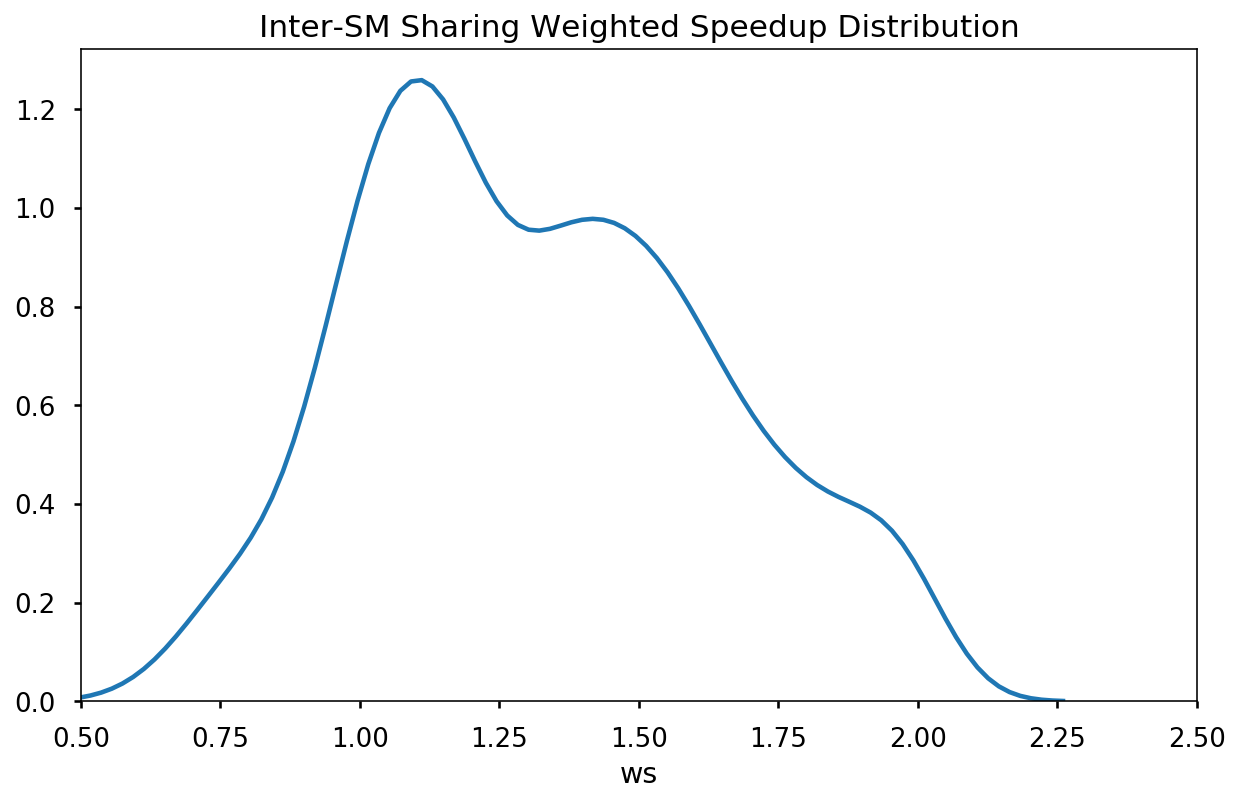

In [200]:
print('=== inter-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_inter_show))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_show['ws']))
# print('Naive prediction average delta: %.2f'% np.average(df_inter_show['delta']))

print('-'*30)

df_gt_1_inter = df_inter_show[df_inter_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_show.index)))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['ws']))
# print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

print('-'*30)

df_gt_15_inter = df_inter_show[df_inter_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_show.index)))
print('WS geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['ws']))
# print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_inter['ws'], hist=False, rug=False);
plt.xlim([0.5, 2.5])
plt.title('Inter-SM Sharing Weighted Speedup Distribution')
plt.show()

In [265]:
# print('=== Ideal inter-SM stats ===')
# # predicted norm_ipc_sum of inter-SM
# df_inter_max = df_inter.dropna()
# print('** Total **')
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_max['norm_ipc_sum']))

# print('-'*30)

# df_gt_1_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.0]
# print('** Greater than 1.0 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['norm_ipc_sum']))
# # print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

# print('-'*30)

# df_gt_15_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.5]
# print('** Greater than 1.5 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['norm_ipc_sum']))
# # print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_inter_max['norm_ipc_sum'], hist=False, rug=True);
# plt.title('(Ideal) Inter-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Intra-SM sharing pairs

In [69]:
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
print(df_dynamic.shape)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)


(1202, 208)


In [70]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_show = ['1_bench', '1_intra', 
                    '2_bench', '2_intra', 'sld', 'ws', 'fairness']
draw_table(df_dynamic_show, col_dynamic_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                             'avg_dram_bw_y':'{:.4f}',
                                                             'sum_bw_x':'{:.4f}'
                                                            })

,1_bench,1_intra,2_bench,2_intra,sld,ws,fairness
0,nvd_binomial-0,13,rod_heartwall-0,1,"[0, 1.102623091150889, 0.9335640074737808]",2.03619,0.846676
1,nvd_binomial-0,8,parb_spmv-0,8,"[0, 0.91003654907126, 1.1017371215593863]",2.01177,0.826002
2,parb_cutcp-0,2,parb_spmv-0,8,"[0, 0.956847589561719, 1.0545723959678257]",2.01142,0.907332
3,nvd_interval-0,6,parb_cutcp-0,2,"[0, 1.0313510377723345, 0.9645662622668414]",1.99592,0.935245
4,parb_cutcp-0,2,rod_heartwall-0,1,"[0, 0.9965384997269523, 0.9855968873224692]",1.98214,0.98902
5,parb_cutcp-0,2,rod_streamcluster-0,2,"[0, 0.9776199544144004, 1.0001605727725251]",1.97778,0.977463
6,rod_heartwall-0,1,rod_lavamd-0,6,"[0, 0.8902873660567351, 1.0776823245259448]",1.96797,0.826113
7,nvd_interval-0,6,rod_heartwall-0,1,"[0, 1.024005969813021, 0.9426297214087257]",1.96664,0.920531
8,nvd_blackscholes-0,6,rod_lavamd-0,6,"[0, 0.8951984300161824, 1.05991253391557]",1.95511,0.844597
9,nvd_blackscholes-0,8,parb_cutcp-0,2,"[0, 0.9900782076568806, 0.959075147546623]",1.94915,0.968686


In [190]:
draw_table(df_dynamic_show[(df_dynamic_show['1_bench']=='cut_wmma-0')&
                           (df_dynamic_show['2_bench']=='nvd_binomial-0')], 
           col_dynamic_show)

1_bench,1_intra,2_bench,2_intra,sld,ws,fairness
cut_wmma-0,2,nvd_binomial-0,8,"[0, 0.9056662910531854, 0.8774405363964634]",1.78311,0.968834


=== intra-SM stats ===
** Total **
Pairs:  168
WS geomean: 1.4171
------------------------------
** Greater than 1.0 WS **
Proportion: 0.90
WS geomean: 1.4987
------------------------------
** Greater than 1.5 WS **
Proportion: 0.49
WS geomean: 1.7133


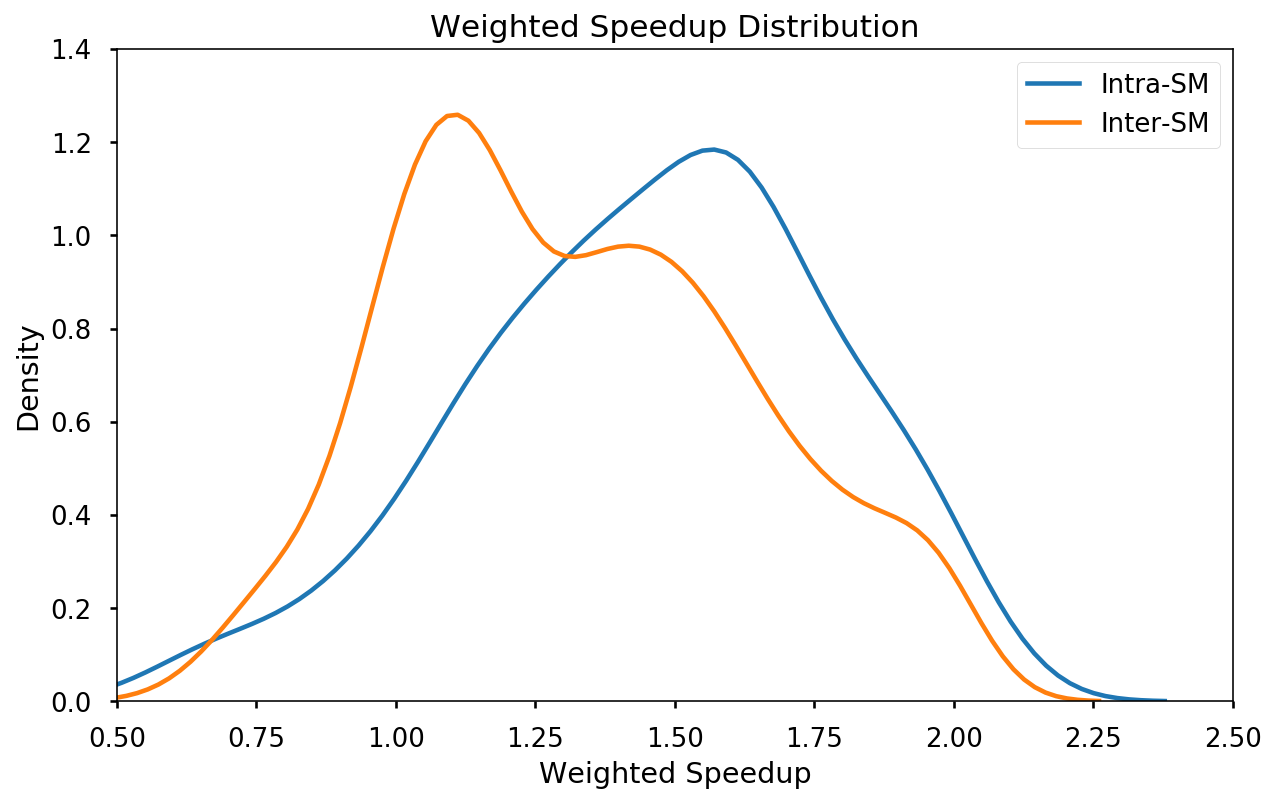

In [201]:
print('=== intra-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_dynamic_show.index))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['ws']))
# print('Naive prediction average delta: %.2f' % np.average(df_dynamic_show['delta']))

print('-'*30)

df_gt_1_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['ws']))
# print('Greater than 1.0 naive delta: %.2f' % np.average(df_gt_1_intra['delta']))

print('-'*30)

df_gt_15_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['ws']))
# print('Greater than 1.5 naive delta: %.2f' % np.average(df_gt_15_intra['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_dynamic_show['ws'], hist=False, rug=False, label='Intra-SM');
sns.distplot(df_inter['ws'], hist=False, rug=False, label='Inter-SM');
plt.xlim([0.5, 2.5])
plt.ylim([0, 1.4])
plt.xlabel('Weighted Speedup')
plt.ylabel('Density')
plt.legend()
plt.title('Weighted Speedup Distribution')
plt.show()

In [266]:
# print('=== Ideal intra-SM stats ===')
# print('** Total **')
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['sum_ipc']))

# print('-'*30)

# df_gt_1_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.0]
# print('** Greater than 1.0 WS **')
# print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['sum_ipc']))

# print('-'*30)

# df_gt_15_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.5]
# print('** Greater than 1.5 WS **')
# print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['sum_ipc']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_dynamic_show['sum_ipc'], hist=False, rug=True);
# plt.title('(Ideal) Intra-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Compare Inter-SM and Intra-SM

In [171]:
df_both = pd.merge(df_inter_show, df_dynamic_show, on=['1_bench', '2_bench'], suffixes=('_inter', '_intra'))
df_both['intra-inter'] = df_both['ws_intra'] - df_both['ws_inter']

col_both = ['1_bench', '2_bench', #'ws_inter', 'ws_intra', 
            'intra-inter', 
            '1_sld_inter', '2_sld_inter', '1_sld_intra', '2_sld_intra',
            '1_conc_cta_delta', '2_conc_cta_delta',
            '1_intra', '2_intra', '1_inter', '2_inter',
           ]

df_both['1_conc_cta_delta'] = df_both['1_conc_cta_intra'] - df_both['1_conc_cta_inter']
df_both['2_conc_cta_delta'] = df_both['2_conc_cta_intra'] - df_both['2_conc_cta_inter']

def highlight_error(s):
    is_neg = s < 0
    return ['background-color: yellow' if v else '' for v in is_neg]


df_both_display = df_both#[df_both['intra-inter']<0]

# Filter 1: small grids
# small_grid = ['parb_cutcp-0', 'rod_heartwall-0', 'rod_streamcluster-0']
# df_both_display = df_both_display[(~df_both_display['1_bench'].isin(small_grid))&(~df_both_display['2_bench'].isin(small_grid))]

# Filter 2: target = 'rod_hotspot-0'
# df_both_display = df_both_display[(df_both_display['1_bench']==target)|(df_both_display['2_bench']==target)]
# df_both_display = df_both_display.sort_values('intra-inter')

print('Num of rows: ', df_both_display.shape[0])
draw_table(df_both_display, col_both, True).apply(highlight_error, subset=['intra-inter'])

Num of rows:  164


1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,1_conc_cta_delta,2_conc_cta_delta,1_intra,2_intra,1_inter,2_inter
parb_cutcp-0,rod_heartwall-0,-0.0232339,1.00292,1.00245,0.996538,0.985597,0,0,2,1,56,24
nvd_interval-0,rod_heartwall-0,-0.0211501,1.00701,0.98078,1.02401,0.94263,-288,0,6,1,64,16
nvd_interval-0,parb_cutcp-0,0.011332,0.997177,0.987409,1.03135,0.964566,-288,0,6,2,64,16
parb_cutcp-0,rod_streamcluster-0,-0.00469061,0.998415,0.984057,0.97762,1.00016,0,0,2,2,32,48
nvd_blackscholes-0,parb_cutcp-0,-0.0224578,0.979196,0.992415,0.990078,0.959075,0,0,8,2,40,40
cut_wmma-2,parb_cutcp-0,-0.137783,0.974179,0.983821,0.970984,0.849234,-16,0,3,2,64,16
cut_wmma-0,rod_heartwall-0,-0.0870119,0.992655,0.965096,0.977795,0.892944,0,0,2,1,48,24
cut_wmma-0,parb_cutcp-0,-0.0764601,0.957589,0.999404,0.920227,0.960306,0,0,2,2,48,32
parb_cutcp-0,parb_stencil-0,-0.0182836,0.963814,0.972226,0.935185,0.982571,0,0,2,13,16,64
parb_cutcp-0,parb_spmv-0,0.0888021,0.97666,0.945958,0.956848,1.05457,0,-384,2,8,16,64


In [172]:
target = 'cut_sgemm-1'
df_both_display = df_both#[df_both['intra-inter']<0]
df_both_display = df_both_display[(df_both_display['1_bench']==target)|(df_both_display['2_bench']==target)]

df_both_display = df_both_display.sort_values('intra-inter')

print('Num of rows: ', df_both_display.shape[0])
draw_table(df_both_display, col_both, True).apply(highlight_error, subset=['intra-inter'])

Num of rows:  17


1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,1_conc_cta_delta,2_conc_cta_delta,1_intra,2_intra,1_inter,2_inter
cut_sgemm-1,parb_cutcp-0,-0.272538,0.823803,0.987024,0.648493,0.889796,-48,0,1,2,64,16
cut_sgemm-1,rod_heartwall-0,-0.184202,0.82308,0.994354,0.661399,0.971833,-48,0,1,1,64,16
cut_sgemm-1,parb_lbm-0,-0.162424,0.776246,0.706633,0.58197,0.738485,-48,-32,1,2,64,16
cut_sgemm-1,rod_streamcluster-0,-0.0267021,0.661471,0.505656,0.655984,0.484441,-32,8,1,1,56,24
cut_sgemm-1,nvd_blackscholes-0,0.0721369,0.551294,0.843904,0.582801,0.884534,-16,128,1,8,48,32
cut_sgemm-1,parb_stencil-0,0.0809606,0.54772,0.703166,0.612797,0.719049,-16,128,1,8,48,32
cut_sgemm-1,rod_hotspot3d-0,0.0900619,0.551767,0.64979,0.621185,0.670434,-16,64,1,4,48,32
cut_sgemm-1,nvd_binomial-0,0.150992,0.479536,0.489423,0.411826,0.708124,0,0,1,8,40,40
cut_sgemm-1,cut_wmma-0,0.155716,0.555283,0.834379,0.630885,0.914493,-16,0,1,2,48,32
cut_sgemm-1,nvd_interval-0,0.162857,0.556717,0.87597,0.649278,0.946267,-16,96,1,6,48,32


In [173]:
# Check which kernel prefers inter over intra and vice versa

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_seq.set_index('pair_str', inplace=True)
THRESHOLD = 0.01

pref = []
for kernel in const.get_single_kernel_app():
    series = {}

    df_kernel = df_both[(df_both['1_bench']==kernel) | (df_both['2_bench']==kernel)]
    
    series['kernel'] = kernel
    prefer_inter = df_kernel[df_kernel['intra-inter'] < -1 * THRESHOLD]
    prefer_intra = df_kernel[df_kernel['intra-inter'] > THRESHOLD]
    series['prefer_inter'] = len(prefer_inter.index)
    series['prefer_intra'] = len(prefer_intra.index)
    series['same'] = len(df_kernel.index) - series['prefer_inter'] - series['prefer_intra']
    
    series['avg_delta'] = np.average(df_kernel['intra-inter'])
    series['delta_inter'] = np.average(prefer_inter['intra-inter']) if series['prefer_inter'] > 0 else 0
    series['delta_intra'] = np.average(prefer_intra['intra-inter']) if series['prefer_intra'] > 0 else 0
    
    series['stall_sm'] = (df_seq.loc[kernel, 'stall_sp_cycles'] + \
                          df_seq.loc[kernel, 'stall_dp_cycles'] + \
                          df_seq.loc[kernel, 'stall_int_cycles'] + \
                          df_seq.loc[kernel, 'stall_sfu_cycles'] + \
                          df_seq.loc[kernel, 'stall_tensor_cycles']  + \
                          df_seq.loc[kernel, 'not_selected_cycles']) / df_seq.loc[kernel, 'cycles_per_issue']

    series['not_selected'] = df_seq.loc[kernel, 'not_selected_cycles']
    series['grid'] = const.get_grid_size(kernel)
    series['max_cta/SM'] = const.get_max_cta_per_sm(kernel)
    series['l2_bw'] = df_seq.loc[kernel, 'l2_bw']
    series['avg_core_to_l2'] = df_seq.loc[kernel, 'avg_core_to_l2']
    series['ipc'] = df_seq.loc[kernel, 'ipc']

    pref.append(series)
    
df_pref = pd.DataFrame(pref)

df_pref['waves'] = df_pref['grid'] / df_pref['max_cta/SM'] / const.num_sm_volta
df_pref.sort_values(['avg_delta'], inplace=True)
df_pref.reset_index(inplace=True, drop=True)

In [174]:
pref_col = ['kernel', 'prefer_inter', 'prefer_intra', 'same', 'avg_delta', 'delta_inter', 'delta_intra',
            'l2_bw', 'avg_core_to_l2', 
            'stall_sm', 'waves', #'grid', 'max_cta/SM'
           ]
draw_table(df_pref, pref_col, False).format({'waves': '{:.2f}',
                                             'stall_sm': '{:.4f}',
                                             'avg_delta': '{:.2f}',
                                             'delta_inter': '{:.2f}',
                                             'delta_intra': '{:.2f}'})

,kernel,prefer_inter,prefer_intra,same,avg_delta,delta_inter,delta_intra,l2_bw,avg_core_to_l2,stall_sm,waves
0,parb_lbm-0,14,3,1,-0.09,-0.16,0.19,525.39,15705,0.0012,18.75
1,parb_cutcp-0,11,5,2,-0.05,-0.10,0.07,8.3789,32,0.0000,0.09
2,rod_heartwall-0,10,7,1,-0.01,-0.11,0.13,126.107,35,0.0000,0.13
3,rod_streamcluster-0,12,5,1,0.02,-0.10,0.29,679.804,57,0.0012,0.53
4,parb_stencil-0,7,9,2,0.03,-0.05,0.09,854.951,199,0.0014,0.80
5,rod_hotspot3d-0,5,10,3,0.04,-0.08,0.12,820.035,76,0.0071,1.60
6,nvd_blackscholes-0,6,10,2,0.05,-0.05,0.12,686.447,1109,0.0028,12.21
7,cut_sgemm-0,4,13,0,0.06,-0.19,0.14,195.634,103,0.0411,0.80
8,cut_wmma-0,8,9,1,0.07,-0.09,0.21,308.317,112,0.0000,0.40
9,nvd_interval-0,5,13,0,0.07,-0.09,0.13,138.489,72,0.0045,1.07


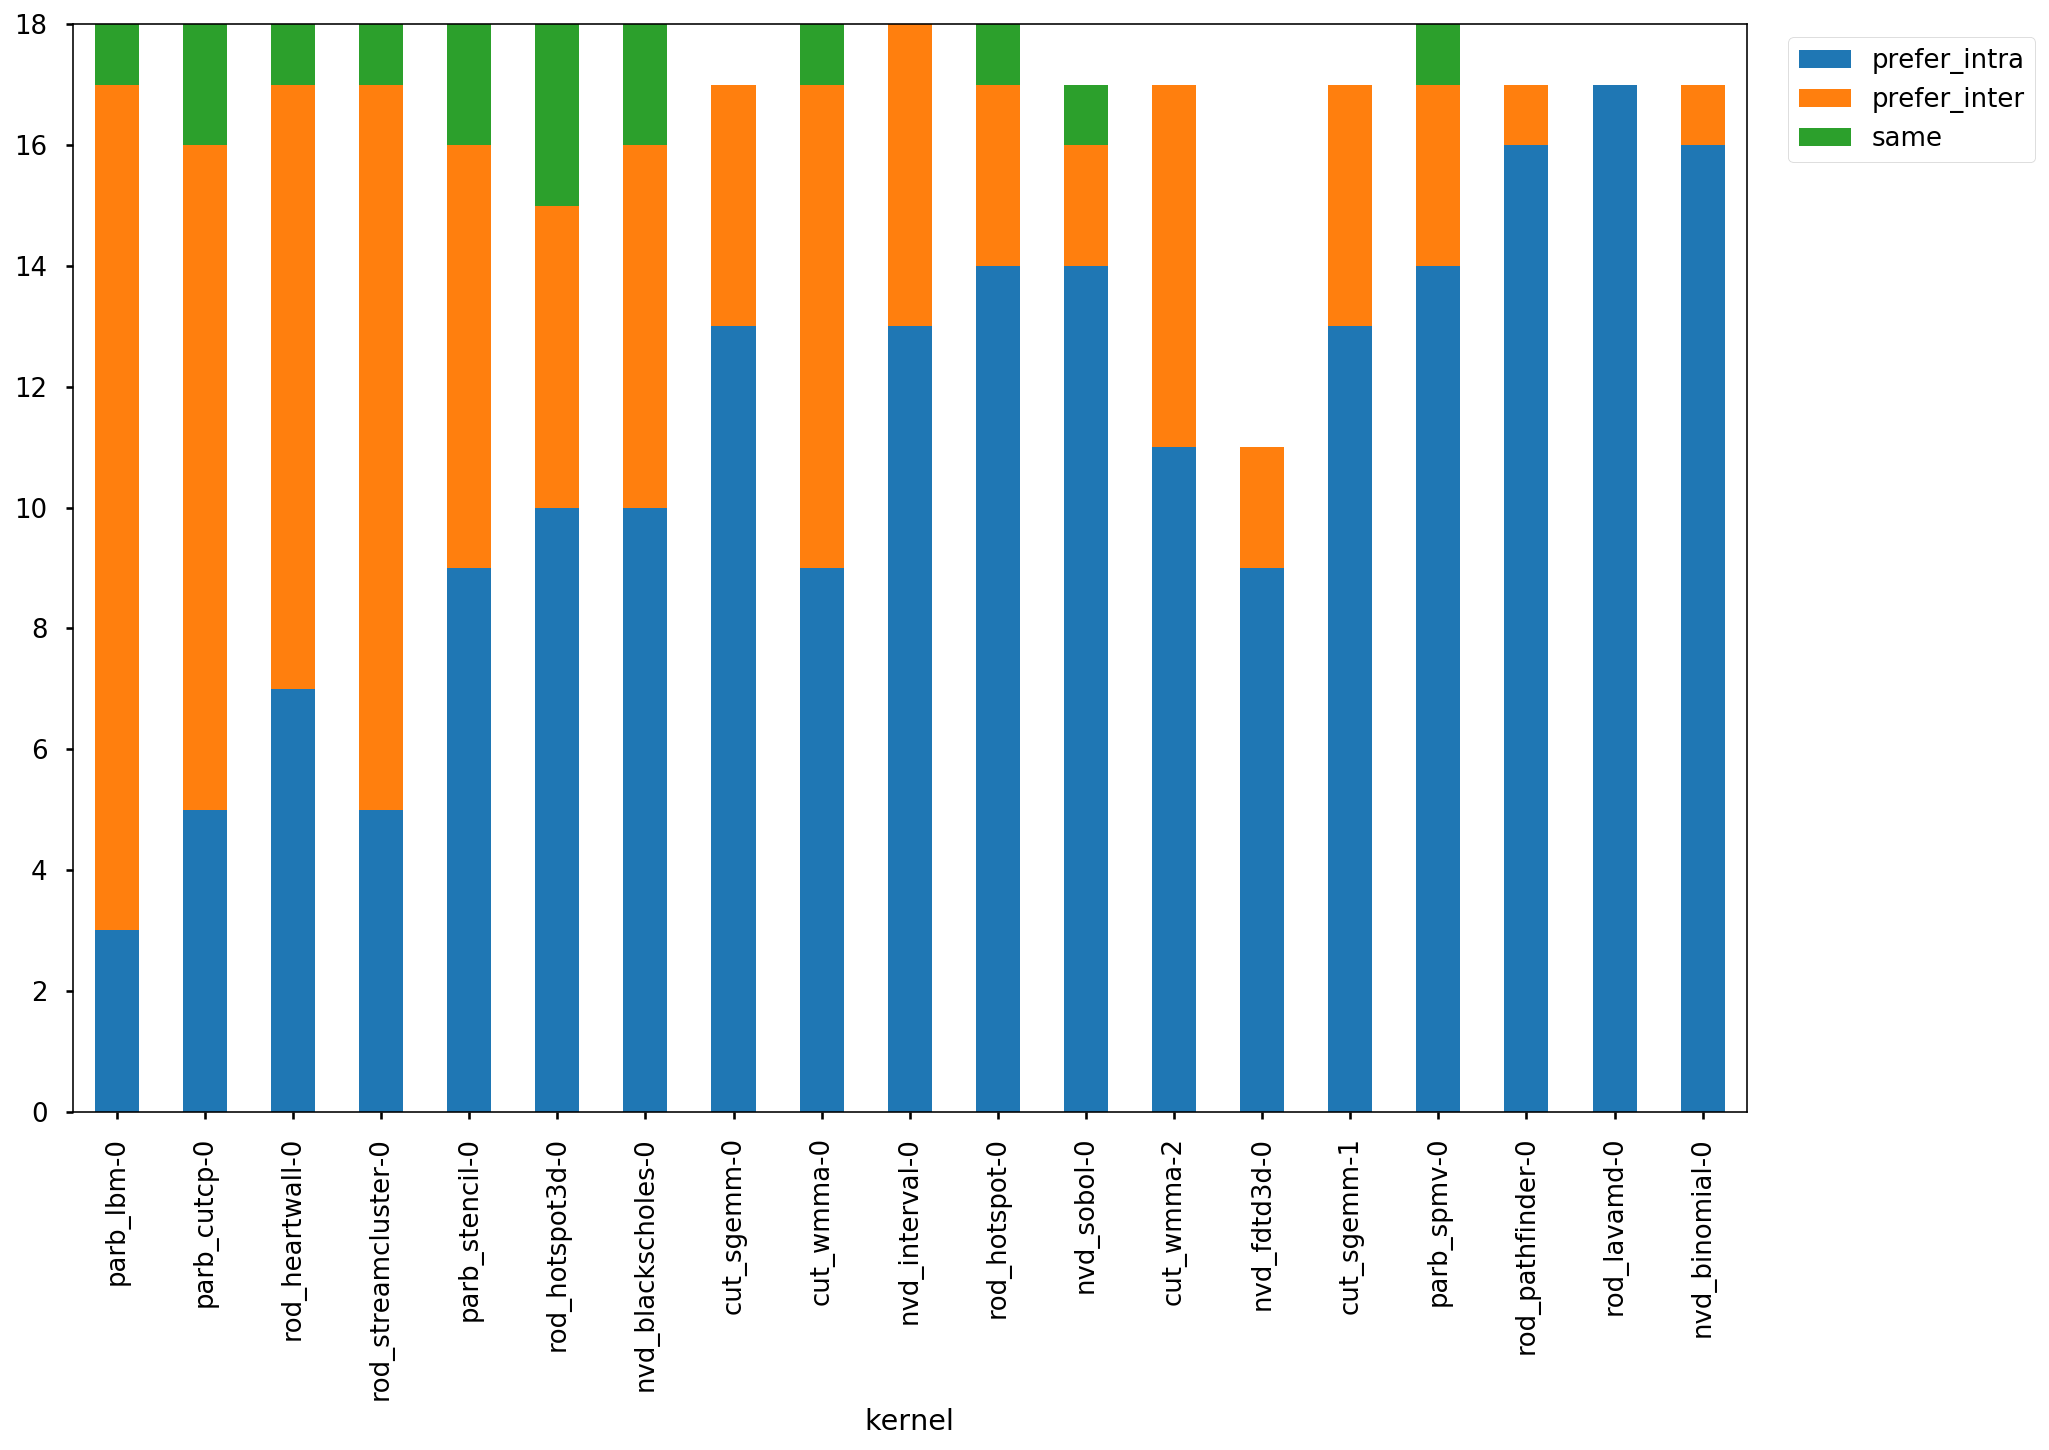

In [175]:
ax = df_pref[['kernel', 'prefer_intra', 'prefer_inter', 'same']].set_index('kernel').plot(kind='bar', 
                                                                                     stacked=True, 
                                                                                     ylim=(0, 18),
                                                                                     figsize=(15,10)
                                                                                    )
ax.legend(bbox_to_anchor=(1.18, 1))
plt.show()

# Compare C+C pairs

In [181]:
def highlight_usage(s):
    colors = []
    for v in s:
        if v < 0.1:
            colors.append('background-color: green')
        elif v < 0.2:
            colors.append('background-color: yellow')
        else:
            colors.append('background-color: red')
    return colors

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))

col_seq = ['pair_str', 'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy']
draw_table(df_seq, col_seq, False).apply(highlight_usage, 
                                         subset=['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy'])


,pair_str,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy
5,cut_sgemm-0,0.136789,0,0.070351,0,0
18,cut_sgemm-1,0.328146,0,0.137243,0,0
10,cut_wmma-0,0.000857,0,0.04601,0.21262,0
6,cut_wmma-2,0.000551,0,0.106494,0.5469,0
0,nvd_binomial-0,0.364782,0,0.037742,0,0.001009
12,nvd_blackscholes-0,0.136019,0,0.029569,0,0.147846
13,nvd_fdtd3d-0,0.050058,0,0.021077,0,0
7,nvd_interval-0,0,0.247979,0.028627,0,0.255307
4,nvd_sobol-0,0.017089,0,0.481519,0,0
17,parb_cutcp-0,0.035736,0,0.010982,0,0.018006


In [188]:
BW_THRESHOLD = 0.5
MPKI_THRESHOLD = 3

# df_mem = df_seq[df_seq['avg_dram_bw'] > BW_THRESHOLD]
df_mem = df_seq[df_seq['MPKI'] > MPKI_THRESHOLD]
print('Memory intensive kernels: ', len(df_mem.index))
df_mem.set_index('pair_str', inplace=True)

df_comp = df_seq[df_seq['avg_dram_bw'] < BW_THRESHOLD]
df_comp = df_seq[df_seq['MPKI'] < MPKI_THRESHOLD]
print('Compute intensive kernels: ', len(df_comp.index))
df_comp.set_index('pair_str', inplace=True)

Memory intensive kernels:  8
Compute intensive kernels:  11


In [189]:
def comp_comp(row):
    return row['1_bench'] in df_comp.index and row['2_bench'] in df_comp.index

def mem_mem(row):
    return row['1_bench'] in df_mem.index and row['2_bench'] in df_mem.index

def comp_mem(row):
    cm = row['1_bench'] in df_comp.index and row['2_bench'] in df_mem.index
    mc = row['1_bench'] in df_mem.index and row['2_bench'] in df_comp.index
    return  cm or mc

df_cc = df_both[df_both.apply(comp_comp, axis=1)].copy()
df_cc.reset_index(inplace=True, drop=True)

df_mm = df_both[df_both.apply(mem_mem, axis=1)].copy()
df_mm.reset_index(inplace=True, drop=True)

df_cm = df_both[df_both.apply(comp_mem, axis=1)].copy()
df_cm.reset_index(inplace=True, drop=True)

def sum_usage(row, metric):
    return (df_comp.loc[row['1_bench'], metric] > 0.1) and (df_comp.loc[row['2_bench'], metric] > 0.1)

df_cc['sp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sp_busy'), axis=1)
df_cc['dp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'dp_busy'), axis=1)
df_cc['int_sum'] = df_cc.apply(lambda row: sum_usage(row, 'int_busy'), axis=1)
df_cc['tensor_sum'] = df_cc.apply(lambda row: sum_usage(row, 'tensor_busy'), axis=1)
df_cc['sfu_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sfu_busy'), axis=1)

df_cc['1_conc_cta_delta'] = df_cc['1_conc_cta_intra'] - df_cc['1_conc_cta_inter']
df_cc['2_conc_cta_delta'] = df_cc['2_conc_cta_intra'] - df_cc['2_conc_cta_inter']

col_cc = col_both + ['1_conc_cta_delta', '2_conc_cta_delta', 
                     'sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum']

def highlight_conflict(s):
    is_conflict = (s == True)
    return ['background-color: yellow' if v else '' for v in is_conflict]

# df_cc[col_cc]
print('C+C average inter-SM WS: ', scipy.stats.mstats.gmean(df_cc['ws_inter']))
print('C+C average intra-SM WS: ', scipy.stats.mstats.gmean(df_cc['ws_intra']))
print('-' * 20)

print('C+M average inter-SM WS: ', scipy.stats.mstats.gmean(df_cm['ws_inter']))
print('C+M average intra-SM WS: ', scipy.stats.mstats.gmean(df_cm['ws_intra']))
print('-' * 20)

print('M+M average inter-SM WS: ', scipy.stats.mstats.gmean(df_mm['ws_inter']))
print('M+M average intra-SM WS: ', scipy.stats.mstats.gmean(df_mm['ws_intra']))
print('-' * 20)
# draw_table(df_cc, col_cc, False).apply(highlight_conflict, 
#                                        subset=['sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum'])

C+C average inter-SM WS:  1.3128741784589406
C+C average intra-SM WS:  1.5217621308549765
--------------------
C+M average inter-SM WS:  1.427343240329654
C+M average intra-SM WS:  1.4806732605413158
--------------------
M+M average inter-SM WS:  1.0823152626254076
M+M average intra-SM WS:  1.0711734449156574
--------------------


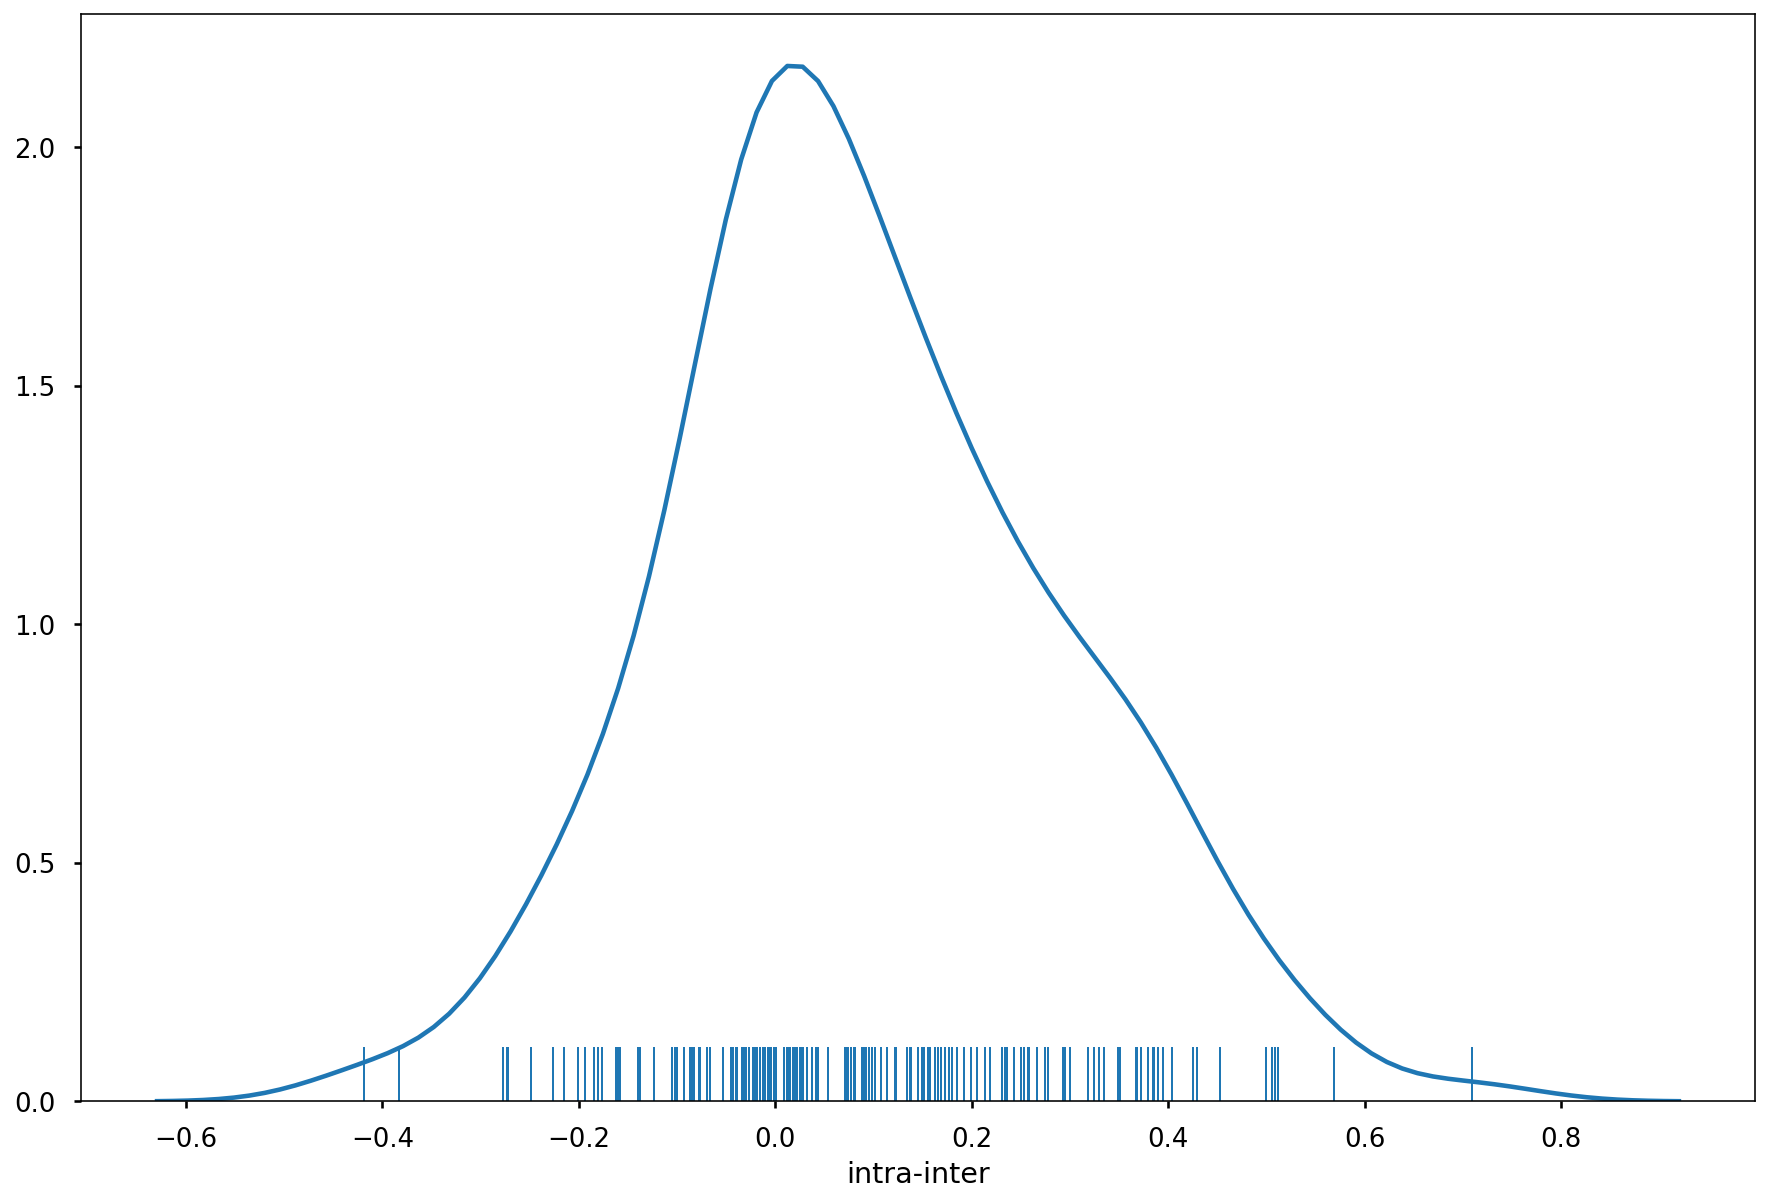

In [184]:
plt.figure(figsize=(15, 10))
sns.distplot(df_both['intra-inter'], hist=False, rug=True);
plt.show()

# Compare CUDA stream with Intra-SM

In [46]:
df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq-titanv.pkl'))

In [202]:
print("Volta Execution Context Storage per SM:")
print("Register File: 64K * 32-bit registers")
print("Shared Memory: 96 KB")
print("Thread slots: 2048 threads")
print("Thread block slot: 32 TBs")

Volta Execution Context Storage per SM:
Register File: 64K * 32-bit registers
Shared Memory: 96 KB
Thread slots: 2048 threads
Thread block slot: 32 TBs


In [60]:
apps = ['nvd_blackscholes-0', 'rod_lavamd-0']

width=800
xlim = 5200000

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_blackscholes comes first", width=width, xmax=xlim).display()
gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: rod_lavamd comes first", width=width, xmax=xlim).display()
print("nvd_blackscholes-0: 16 CTAs/SM => 100% thread slots")
print("rod_lavamd-0: 9 CTAs/SM => 98% registers")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_blackscholes-0: 6 CTAs/SM")
print("rod_lavamd-0: 6 CTAs/SM")

alt.LayerChart(...)

alt.LayerChart(...)

nvd_blackscholes-0: 16 CTAs/SM
rod_lavamd-0: 9 CTAs/SM


alt.LayerChart(...)

nvd_blackscholes-0: 6 CTAs/SM
rod_lavamd-0: 6 CTAs/SM


In [59]:
apps = ['nvd_binomial-0', 'parb_stencil-0']

width=1000
xlim = None

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_binomial comes first", width=width, xmax=xlim).display()
gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: parb_stencil comes first", width=width, xmax=xlim).display()
print("nvd_binomial-0: 12-13 CTAs/SM (max 16 CTAs/SM)")
print("parb_stencil-0: 12-13 CTAs/SM (max 16 CTAs/SM)")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_binomial-0: 8 CTAs/SM")
print("parb_stencil-0: 4 CTAs/SM")

alt.LayerChart(...)

alt.LayerChart(...)

nvd_binomial-0: 12-13 CTAs/SM (max 16 CTAs/SM)
parb_stencil-0: 12-13 CTAs/SM (max 16 CTAs/SM)


alt.LayerChart(...)

nvd_binomial-0: 8 CTAs/SM
parb_stencil-0: 4 CTAs/SM


In [52]:
apps = ['nvd_fdtd3d-0', 'rod_heartwall-0']

width=1600
xlim = 2300000

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_fdtd3d comes first", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: rod_heartwall comes first", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM


alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM


alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM
